# Outlier detection with weather data of Tokyo region
## From datasets of 30 years of daily weather
http://www.data.jma.go.jp/obd/stats/etrn/index.php

## Objective

Objective of this notebook is to detect outliers in daily weather over 30 years of weather data of Tokyo region. The dataset is acquired from [Japan Meteorogical Agency](http://www.data.jma.go.jp/obd/stats/etrn/index.php).
I used unsupervised learning from scikit-learn, the methodologies include one class svm, kernel density estimator, local outlier factor, gaussian mixture, isolation forest and elliptic envelope.

### Thanks to the following decks:
https://www.slideshare.net/KosukeNakago/dllab-20180214-88470902 <br>
http://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html <br>
http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#sphx-glr-auto-examples-covariance-plot-outlier-detection-py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
import copy

%matplotlib inline

## Prerequisite
The dataset is acquired from [Japan Meteorogical Agency](http://www.data.jma.go.jp/obd/stats/etrn/index.php), daily, from January 1st, 1987, to December 31, 2017. <br>
The columns I selected are as follows:<br>
- average temperature
- highest temperature
- lowest temperature
- precipitation
- daylight time
- snowfall 
- average wind speed
- highest wind speed
- highest wind direction

In [2]:
# load dataset
weather = pd.read_csv("./1987-2017.csv")
months = ["Jan","Feb","Mar","Apr","May","Jun",
          "Jul","Aug","Sep","Oct","Nov","Dec"]

In [3]:
weather

,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
0,1987/1/1,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,12.7,NNW
1,1987/1/2,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,7.8,NNW
2,1987/1/3,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,5.9,N
3,1987/1/4,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,8.0,NNW
4,1987/1/5,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,8.0,N
5,1987/1/6,1987,1,6,3.5,6.7,0.4,3.0,5.7,5,3.3,7.5,NNW
6,1987/1/7,1987,1,7,5.0,8.7,2.7,0.0,2.5,0,2.9,6.0,N
7,1987/1/8,1987,1,8,8.7,15.1,2.5,0.0,7.6,0,3.4,6.4,NW
8,1987/1/9,1987,1,9,8.7,15.4,3.1,0.0,8.9,0,2.4,5.5,NNW
9,1987/1/10,1987,1,10,4.3,8.3,1.5,0.0,4.4,0,4.8,9.4,N


In [4]:
# dividing the original dataset to monthly datasets
orig_monthly_weathers = {}
for i in range(1,13,1):
    orig_monthly_weathers[i] = weather.query("month=={0}".format(i))
    orig_monthly_weathers[i].reset_index(inplace=True, drop=True)

### Drawing boxplot on each month, in order to see if there are outliers
It is possible to observe from the boxplots that there are obvious outliers in the dataset.

/opt/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2081: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:2082: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


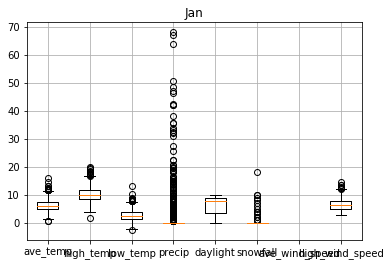

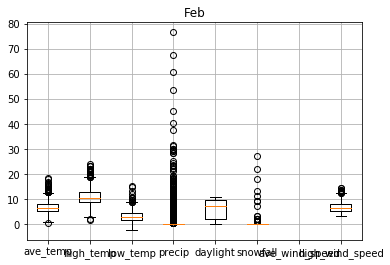

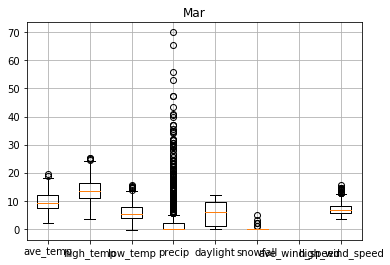

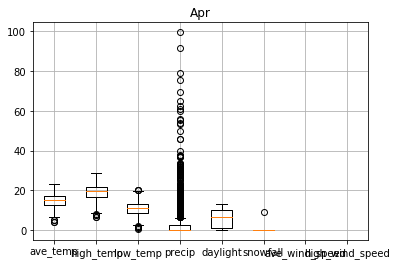

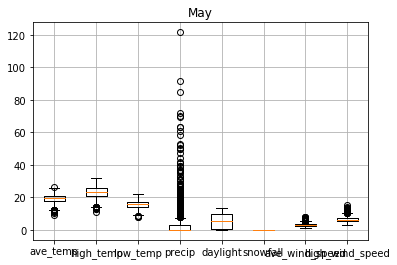

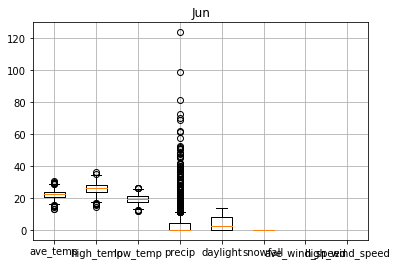

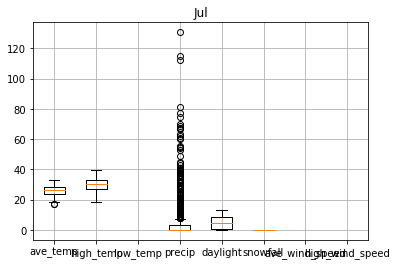

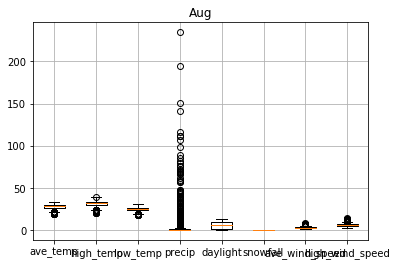

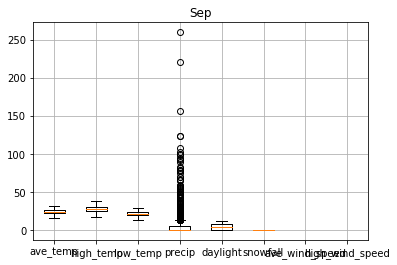

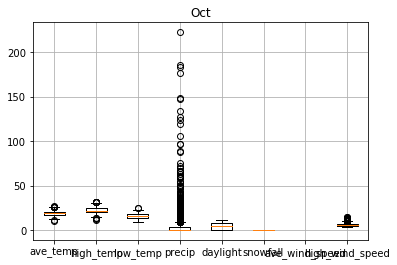

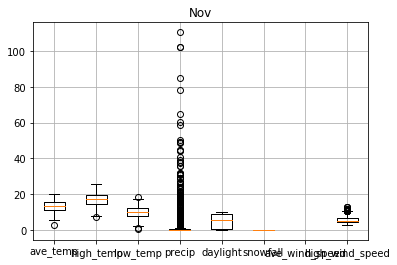

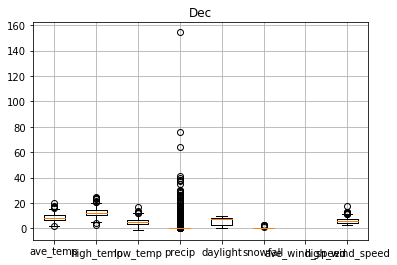

In [5]:
r = ['ave_temp', 'high_temp', 'low_temp', 'precip','daylight', 'snowfall', 'ave_wind_speed', 'high_wind_speed']
for i in range(1,13,1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(np.array(orig_monthly_weathers[i][r]))
    ax.set_xticklabels(r)
    plt.title(months[i-1])
    plt.grid()
    plt.show()

## Data refining and cleansing
In order to refine and cleanse data, I did followings:
- identified columns to use on outlier detection
- transpose nominal scale data to numerical scale
- imputed null values
- rescaled continuous variables to standard scale

In [6]:
# get dummy columns for high_wind_direc to tranpose nominal scale to numerical scale
high_wind_dummies = pd.get_dummies(weather[["high_wind_direc"]])
weather_con = pd.merge(weather, high_wind_dummies, left_index=True, right_index=True)

In [7]:
weather_con

,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987/1/1,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,...,1,0,0,0,0,0,0,0,0,0
1,1987/1/2,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,...,1,0,0,0,0,0,0,0,0,0
2,1987/1/3,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,...,0,0,0,0,0,0,0,0,0,0
3,1987/1/4,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,...,1,0,0,0,0,0,0,0,0,0
4,1987/1/5,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
5,1987/1/6,1987,1,6,3.5,6.7,0.4,3.0,5.7,5,...,1,0,0,0,0,0,0,0,0,0
6,1987/1/7,1987,1,7,5.0,8.7,2.7,0.0,2.5,0,...,0,0,0,0,0,0,0,0,0,0
7,1987/1/8,1987,1,8,8.7,15.1,2.5,0.0,7.6,0,...,0,1,0,0,0,0,0,0,0,0
8,1987/1/9,1987,1,9,8.7,15.4,3.1,0.0,8.9,0,...,1,0,0,0,0,0,0,0,0,0
9,1987/1/10,1987,1,10,4.3,8.3,1.5,0.0,4.4,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# columns names after concatenating the dummy columns
weather_con.columns

Index(['yyyy/mm/dd', 'year', 'month', 'day', 'ave_temp', 'high_temp',
       'low_temp', 'precip', 'daylight', 'snowfall', 'ave_wind_speed',
       'high_wind_speed', 'high_wind_direc', 'high_wind_direc_E',
       'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
       'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
       'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
       'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
       'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW'],
      dtype='object')

In [9]:
# statistics
weather_con.describe()

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
count,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11322.000000,11323.000000,11323.000000,11323.000000,11302.000000,...,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000,11323.000000
mean,2002.000000,6.522830,15.729930,16.514139,20.301387,13.165165,4.335512,5.263296,0.024552,3.221908,...,0.219641,0.086373,0.152963,0.042568,0.054579,0.040537,0.081515,0.001855,0.011039,0.003091
std,8.944825,3.448883,8.800604,7.806724,7.941592,8.055336,13.293315,4.038257,0.523530,1.056939,...,0.414022,0.280926,0.359968,0.201890,0.227167,0.197224,0.273637,0.043027,0.104492,0.055514
min,1987.000000,1.000000,1.000000,0.300000,1.500000,-2.600000,0.000000,0.000000,0.000000,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,4.000000,8.000000,9.350000,13.200000,5.600000,0.000000,0.800000,0.000000,2.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,7.000000,16.000000,16.900000,20.600000,13.400000,0.000000,5.600000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,10.000000,23.000000,22.900000,26.600000,20.000000,1.500000,8.900000,0.000000,3.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,12.000000,31.000000,33.200000,39.500000,30.400000,259.500000,13.800000,27.000000,9.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# a list of columns to use afterwards
columns_to_use = ['year', 'month', 'day', 'ave_temp', 'high_temp',
                  'low_temp', 'precip', 'daylight', 'snowfall', 'ave_wind_speed',
                  'high_wind_speed', 'high_wind_direc_E',
                  'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
                  'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
                  'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
                  'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
                  'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW']
weather_refined = weather_con[columns_to_use]
weather_refined

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,...,0,0,0,0,0,0,0,0,0,0
5,1987,1,6,3.5,6.7,0.4,3.0,5.7,5,3.3,...,1,0,0,0,0,0,0,0,0,0
6,1987,1,7,5.0,8.7,2.7,0.0,2.5,0,2.9,...,0,0,0,0,0,0,0,0,0,0
7,1987,1,8,8.7,15.1,2.5,0.0,7.6,0,3.4,...,0,1,0,0,0,0,0,0,0,0
8,1987,1,9,8.7,15.4,3.1,0.0,8.9,0,2.4,...,1,0,0,0,0,0,0,0,0,0
9,1987,1,10,4.3,8.3,1.5,0.0,4.4,0,4.8,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# dividing the refined weather dataset into each month
monthly_weathers = {}
for i in range(1,13,1):
    monthly_weathers[i] = weather_refined.query("month=={0}".format(i))
    monthly_weathers[i].reset_index(inplace=True, drop=True)
monthly_weathers[1]

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,6.7,9.5,4.0,0.0,9.3,0,7.3,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,2.9,4.7,1.1,2.5,0.0,0,4.4,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,5.9,9.3,1.3,2.0,0.8,0,2.5,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,6.8,11.9,3.2,0.0,8.9,0,4.9,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,2.7,4.7,0.5,6.0,0.0,1,4.2,...,0,0,0,0,0,0,0,0,0,0
5,1987,1,6,3.5,6.7,0.4,3.0,5.7,5,3.3,...,1,0,0,0,0,0,0,0,0,0
6,1987,1,7,5.0,8.7,2.7,0.0,2.5,0,2.9,...,0,0,0,0,0,0,0,0,0,0
7,1987,1,8,8.7,15.1,2.5,0.0,7.6,0,3.4,...,0,1,0,0,0,0,0,0,0,0
8,1987,1,9,8.7,15.4,3.1,0.0,8.9,0,2.4,...,1,0,0,0,0,0,0,0,0,0
9,1987,1,10,4.3,8.3,1.5,0.0,4.4,0,4.8,...,0,0,0,0,0,0,0,0,0,0


### Data cleansing
Let's do two things:
1. impute null values with average values of each month
2. rescale the continuous values to standard scale according to monthly average and deviation

In [12]:
# imputation
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, copy=True)
# standard scaler
ss = preprocessing.StandardScaler()
ss_columns = columns_to_use[3:11]

for m,w in monthly_weathers.items():
    # finding if there's null value
    has_null = [c for c in columns_to_use if len(w[w[c].isnull()]) > 0]
    if has_null != []:
        # impute null values
        w_with_nan = w[has_null]
        imp_w = imp.fit_transform(w_with_nan).T
        for i in range(len(has_null)):
            # replace columns with null to the imputed
            w[has_null[i]] = imp_w[i]
            if len(w[w[has_null[i]].isnull()]) > 0:
                print(has_null[i], len(w[w[has_null[i]].isnull()]))
    # standard scaler
    w[ss_columns] = pd.DataFrame(ss.fit_transform(w[ss_columns]), columns=ss_columns)

/opt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [13]:
# cleansed dataset for January
monthly_weathers[1]

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
0,1987,1,1,0.232739,-0.214742,0.677830,-0.267179,0.921880,-0.112515,3.766289,...,1,0,0,0,0,0,0,0,0,0
1,1987,1,2,-1.588773,-1.975112,-0.772047,0.092428,-1.838478,-0.112515,1.079274,...,1,0,0,0,0,0,0,0,0,0
2,1987,1,3,-0.150737,-0.288090,-0.672056,0.020506,-1.601028,-0.112515,-0.681184,...,0,0,0,0,0,0,0,0,0,0
3,1987,1,4,0.280674,0.665443,0.277864,-0.267179,0.803155,-0.112515,1.542553,...,1,0,0,0,0,0,0,0,0,0
4,1987,1,5,-1.684642,-1.975112,-1.072022,0.595877,-1.838478,0.947555,0.893963,...,0,0,0,0,0,0,0,0,0,0
5,1987,1,6,-1.301166,-1.241624,-1.122017,0.164349,-0.146646,5.187834,0.060062,...,1,0,0,0,0,0,0,0,0,0
6,1987,1,7,-0.582148,-0.508137,0.027885,-0.267179,-1.096446,-0.112515,-0.310561,...,0,0,0,0,0,0,0,0,0,0
7,1987,1,8,1.191430,1.839023,-0.072106,-0.267179,0.417298,-0.112515,0.152717,...,0,1,0,0,0,0,0,0,0,0
8,1987,1,9,1.191430,1.949047,0.227868,-0.267179,0.803155,-0.112515,-0.773839,...,1,0,0,0,0,0,0,0,0,0
9,1987,1,10,-0.917689,-0.654834,-0.572064,-0.267179,-0.532502,-0.112515,1.449897,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# statistics of cleansed January dataset
monthly_weathers[1].describe()

,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,...,high_wind_direc_NNW,high_wind_direc_NW,high_wind_direc_S,high_wind_direc_SE,high_wind_direc_SSE,high_wind_direc_SSW,high_wind_direc_SW,high_wind_direc_W,high_wind_direc_WNW,high_wind_direc_WSW
count,961.000000,961.0,961.000000,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,9.610000e+02,...,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,2002.000000,1.0,16.000000,3.117520e-16,-1.904694e-16,1.943901e-16,6.827698e-17,5.707078e-17,-3.884625e-17,-1.628943e-16,...,0.438085,0.190427,0.036420,0.008325,0.010406,0.014568,0.046826,0.003122,0.024974,0.007284
std,8.948929,0.0,8.948929,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,1.000521e+00,...,0.496410,0.392842,0.187431,0.090906,0.101530,0.119879,0.211376,0.055814,0.156127,0.085080
min,1987.000000,1.0,1.000000,-2.739201e+00,-3.038669e+00,-2.621891e+00,-2.671791e-01,-1.838478e+00,-1.125152e-01,-1.793052e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1994.000000,1.0,8.000000,-6.780167e-01,-6.548342e-01,-6.720555e-01,-2.671791e-01,-7.699525e-01,-1.125152e-01,-7.738393e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.000000,1.0,16.000000,-5.486782e-02,-3.136976e-02,-7.210628e-02,-2.671791e-01,4.469795e-01,-1.125152e-01,-2.179053e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2010.000000,1.0,24.000000,6.162156e-01,5.920946e-01,5.778387e-01,-2.671791e-01,8.328360e-01,-1.125152e-01,6.159958e-01,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017.000000,1.0,31.000000,4.738585e+00,3.599393e+00,5.277441e+00,9.514121e+00,1.099967e+00,1.896874e+01,3.766289e+00,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Outlier detection
Now that the datasets are ready, let's try outlier detections.

In [15]:
# a list of columns used for outlier detection, excluding year, month and day columns
columns_to_analyze = monthly_weathers[1].columns[3:]
columns_to_analyze

Index(['ave_temp', 'high_temp', 'low_temp', 'precip', 'daylight', 'snowfall',
       'ave_wind_speed', 'high_wind_speed', 'high_wind_direc_E',
       'high_wind_direc_ENE', 'high_wind_direc_ESE', 'high_wind_direc_N',
       'high_wind_direc_NE', 'high_wind_direc_NNE', 'high_wind_direc_NNW',
       'high_wind_direc_NW', 'high_wind_direc_S', 'high_wind_direc_SE',
       'high_wind_direc_SSE', 'high_wind_direc_SSW', 'high_wind_direc_SW',
       'high_wind_direc_W', 'high_wind_direc_WNW', 'high_wind_direc_WSW'],
      dtype='object')

In [16]:
# making a dict of number of rows for each month, just for convenience
num_rows = {}
for i in range(1,13,1):
    num_rows[i] = monthly_weathers[i].shape[0]

### defining parameters for outlier detection
I set outlier fraction to 1%.

In [17]:
outliers_fraction = 0.01
rng = np.random.RandomState(123)
anomaly_list = ["ellipticEnvelope", "kernelDensity", "gaussianMixture", 
                "localOutlierFactor", "isolationForest", "oneClassSVM"]

In [18]:
def ellipticEnvelope(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = EllipticEnvelope(contamination=outliers_fraction)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs)
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [19]:
def kernelDensity(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as outliers
            On kernel density estimator, I defined rows with score 
            lower than 1.125 times the average as outliers
    """
    clf = KernelDensity(bandwidth=1, kernel="gaussian")
    clf.fit(inputs)
    score_pred = clf.score_samples(inputs)
    pred = np.where(score_pred <= np.average(score_pred)*1.125, -1, 1)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [20]:
def gaussianMixture(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as outliers
            On kernel density estimator, I defined rows with score 
            lower than 0.7 times the average as outliers
    """
    clf = GaussianMixture(n_components=5, covariance_type="full")
    clf.fit(inputs)
    score_pred = clf.score_samples(inputs)
    pred = np.where(score_pred <= np.average(score_pred)*0.7, -1, 1)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [21]:
def localOutlierFactor(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction)
    clf.fit(inputs)
    score_pred = clf._decision_function(inputs)
    pred = clf._predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [22]:
def isolationForest(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = IsolationForest(contamination=outliers_fraction,
                          max_samples="auto",
                          random_state=rng,
                          n_estimators=100)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs)
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

In [23]:
def oneClassSVM(inputs):
    """
    inputs: dataset
    returns:
        score_pred: evaluated scores on each day
        outlier_rows: rows evaluated as 1% outliers
    """
    clf = svm.OneClassSVM(nu=outliers_fraction,
                          kernel="rbf",
                          gamma=0.03)
    clf.fit(inputs)
    score_pred = clf.decision_function(inputs).T[0]
    pred = clf.predict(inputs)
    outlier_rows = [i for i in range(len(pred)) if pred[i]==-1]
    return score_pred,outlier_rows

## Running each outlier detection on each month

In [24]:
monthly_pred = {}
for m,w in monthly_weathers.items():
    monthly_pred[m] = {}
    # elliptic envelope
    s,o = ellipticEnvelope(w[columns_to_analyze])
    monthly_pred[m]["ellipticEnvelope"] = {"score_pred":s, "outlier_rows":o}
    # kernel density estimator
    s,o = kernelDensity(w[columns_to_analyze])
    monthly_pred[m]["kernelDensity"] = {"score_pred":s, "outlier_rows":o}
    # gaussian mixture
    s,o = gaussianMixture(w[columns_to_analyze])
    monthly_pred[m]["gaussianMixture"] = {"score_pred":s, "outlier_rows":o}
    # local outlier factor
    s,o = localOutlierFactor(w[columns_to_analyze])
    monthly_pred[m]["localOutlierFactor"] = {"score_pred":s, "outlier_rows":o}
    # isolation forest
    s,o = isolationForest(w[columns_to_analyze])
    monthly_pred[m]["isolationForest"] = {"score_pred":s, "outlier_rows":o}
    # one class svm
    s,o = oneClassSVM(w[columns_to_analyze])
    monthly_pred[m]["oneClassSVM"] = {"score_pred":s, "outlier_rows":o}

/opt/anaconda3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/opt/anaconda3/lib/python3.5/site-packages/sklearn/covarianc

### Gathering up

In [25]:
stats_columns = ["MONTH","DATASIZE","NORMALS","ANOMALIES","ANOMALY_RATE"]
outliers = {}
for m in months:
    outliers[m] = {}

ellipticEnvelope


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,951,10,1.04
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,920,10,1.08
4,May,961,951,10,1.04
5,Jun,930,920,10,1.08
6,Jul,961,951,10,1.04
7,Aug,961,951,10,1.04
8,Sep,930,920,10,1.08
9,Oct,961,951,10,1.04


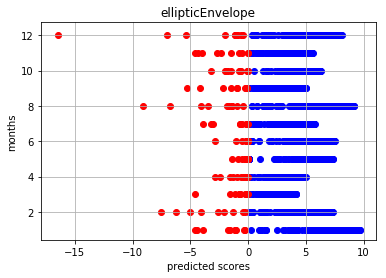

kernelDensity


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,943,18,1.87
1,Feb,876,864,12,1.37
2,Mar,961,961,0,0.0
3,Apr,930,930,0,0.0
4,May,961,960,1,0.1
5,Jun,930,925,5,0.54
6,Jul,961,952,9,0.94
7,Aug,961,942,19,1.98
8,Sep,930,920,10,1.08
9,Oct,961,950,11,1.14


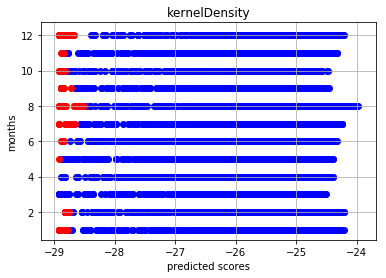

gaussianMixture


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,944,17,1.77
1,Feb,876,837,39,4.45
2,Mar,961,954,7,0.73
3,Apr,930,921,9,0.97
4,May,961,953,8,0.83
5,Jun,930,925,5,0.54
6,Jul,961,957,4,0.42
7,Aug,961,939,22,2.29
8,Sep,930,916,14,1.51
9,Oct,961,917,44,4.58


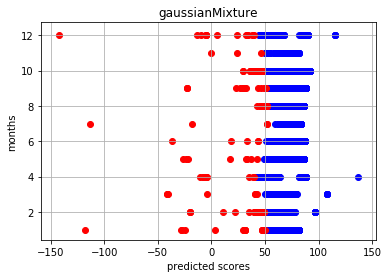

localOutlierFactor


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,953,8,0.83
1,Feb,876,869,7,0.8
2,Mar,961,952,9,0.94
3,Apr,930,922,8,0.86
4,May,961,955,6,0.62
5,Jun,930,922,8,0.86
6,Jul,961,952,9,0.94
7,Aug,961,953,8,0.83
8,Sep,930,921,9,0.97
9,Oct,961,954,7,0.73


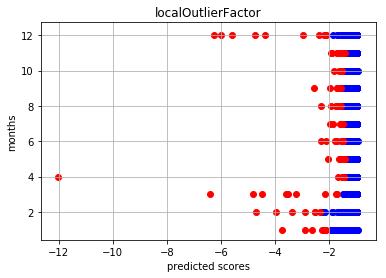

isolationForest


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,951,10,1.04
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,920,10,1.08
4,May,961,951,10,1.04
5,Jun,930,920,10,1.08
6,Jul,961,951,10,1.04
7,Aug,961,951,10,1.04
8,Sep,930,920,10,1.08
9,Oct,961,951,10,1.04


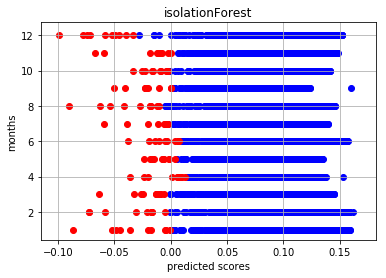

oneClassSVM


,MONTH,DATASIZE,NORMALS,ANOMALIES,ANOMALY_RATE
0,Jan,961,947,14,1.46
1,Feb,876,867,9,1.03
2,Mar,961,951,10,1.04
3,Apr,930,919,11,1.18
4,May,961,947,14,1.46
5,Jun,930,919,11,1.18
6,Jul,961,952,9,0.94
7,Aug,961,950,11,1.14
8,Sep,930,920,10,1.08
9,Oct,961,947,14,1.46


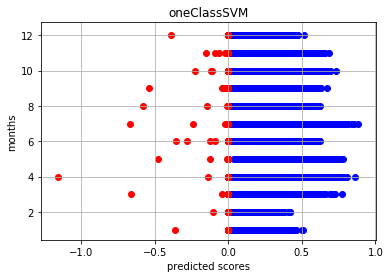

In [26]:
# drawing scatter plots on each algorithm, with month on y-axis
for aa in anomaly_list:
    data_size = []
    oks = []
    ngs = []
    ng_rate = []
    for i in range(1,13,1):
        # gathering outlier and normal rows on each month
        p_ng = monthly_pred[i][aa]["outlier_rows"]
        p_ok = np.delete(np.arange(0,num_rows[i]), p_ng)
        p_ng_score = monthly_pred[i][aa]["score_pred"][p_ng]
        p_ok_score = monthly_pred[i][aa]["score_pred"][p_ok]
        
        data_size.append(num_rows[i])
        oks.append(len(p_ok))
        ngs.append(len(p_ng))
        ng_rate.append(round(100*len(p_ng)/num_rows[i], 2))
        
        for n in p_ng:
            outliers[months[i-1]][n] = 1 if n not in outliers[months[i-1]].keys() else outliers[months[i-1]][n]+1
        
        # scatter plot 
        plt.scatter(p_ok_score, np.zeros(len(p_ok_score))+i, c="blue")
        plt.scatter(p_ng_score, np.zeros(len(p_ng_score))+i, c="red")

    print(aa)
    stats = pd.DataFrame(np.array([months,data_size,oks,ngs,ng_rate]).T, columns=stats_columns)
    display(stats)
    
    plt.title(aa)
    plt.xlabel("predicted scores")
    plt.ylabel("months")
    plt.grid(True)
    plt.show()

In [27]:
# gathered outlier rows on each month
outliers

{'Apr': {37: 3,
  67: 1,
  87: 2,
  158: 1,
  192: 1,
  222: 1,
  262: 1,
  281: 1,
  354: 2,
  367: 1,
  370: 1,
  383: 1,
  465: 2,
  484: 3,
  497: 1,
  536: 1,
  567: 2,
  581: 1,
  608: 1,
  621: 1,
  637: 1,
  647: 4,
  673: 1,
  684: 1,
  685: 1,
  717: 1,
  752: 3,
  782: 1,
  785: 3,
  812: 3,
  876: 1},
 'Aug': {41: 3,
  55: 1,
  62: 4,
  67: 2,
  102: 4,
  149: 1,
  154: 1,
  191: 3,
  212: 6,
  263: 1,
  294: 1,
  332: 3,
  368: 1,
  385: 2,
  395: 1,
  409: 1,
  466: 1,
  468: 1,
  484: 1,
  485: 1,
  509: 1,
  510: 6,
  511: 1,
  512: 1,
  541: 3,
  545: 1,
  554: 1,
  557: 2,
  582: 3,
  583: 1,
  624: 1,
  654: 1,
  655: 2,
  673: 1,
  691: 2,
  712: 3,
  816: 1,
  828: 1,
  850: 1,
  893: 1,
  896: 1,
  915: 1,
  920: 3,
  947: 1,
  952: 1},
 'Dec': {5: 3,
  12: 3,
  29: 2,
  46: 1,
  64: 1,
  80: 2,
  93: 5,
  103: 2,
  104: 2,
  150: 4,
  151: 1,
  162: 3,
  273: 1,
  283: 1,
  392: 1,
  473: 3,
  496: 1,
  531: 5,
  557: 4,
  562: 1,
  614: 5,
  615: 3,
  692: 1,
  

In [28]:
# all the days detected as outlier
for i in range(1,13,1):
    print(months[i-1])
    display(orig_monthly_weathers[i].iloc[list(outliers[months[i-1]].keys()),:])

Jan


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
525,2003/1/30,2003,1,30,3.9,8.6,-0.1,0.0,9.7,0,3.4,6.2,WSW
5,1987/1/6,1987,1,6,3.5,6.7,0.4,3.0,5.7,5,3.3,7.5,NNW
711,2009/1/30,2009,1,30,9.6,11.5,8.3,31.0,0.0,0,2.4,4.9,ENE
712,2009/1/31,2009,1,31,7.8,8.9,5.7,68.0,0.2,0,4.2,7.4,NNW
460,2001/1/27,2001,1,27,1.8,4.5,0.5,33.0,0.0,9,6.3,10.8,NNW
522,2003/1/27,2003,1,27,3.8,5.6,2.4,46.5,0.0,0,2.9,4.5,NNW
331,1997/1/22,1997,1,22,1.7,4.9,-2.1,0.0,9.1,0,7.2,11.9,NNW
12,1987/1/13,1987,1,13,5.0,9.7,0.5,0.0,6.8,4,3.3,8.9,NW
461,2001/1/28,2001,1,28,5.6,10.1,0.4,0.0,7.8,0,2.4,4.7,WSW
143,1991/1/20,1991,1,20,7.6,12.3,3.6,0.0,9.1,0,2.3,4.1,WSW


Feb


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
1,1987/2/2,1987,2,2,0.9,3.4,-0.7,8.5,0.0,3,4.4,6.9,NNW
770,2014/2/8,2014,2,8,0.3,4.0,-0.9,29.5,0.0,22,4.9,9.0,NNW
662,2010/2/13,2010,2,13,2.2,4.0,1.1,0.5,0.0,0,2.5,4.4,NNE
776,2014/2/14,2014,2,14,1.4,5.4,-0.2,28.5,0.0,18,3.8,6.8,NNW
777,2014/2/15,2014,2,15,3.9,6.9,-0.2,67.5,0.5,9,5.4,9.8,NNW
650,2010/2/1,2010,2,1,5.9,9.4,0.6,31.5,0.8,1,2.7,5.8,ENE
651,2010/2/2,2010,2,2,4.2,7.5,1.0,1.5,3.2,1,2.3,4.9,NW
2,1987/2/3,1987,2,3,3.4,4.8,0.7,3.0,2.3,2,3.1,9.4,NW
270,1996/2/17,1996,2,17,0.7,2.0,-0.2,4.5,0.0,7,3.2,5.2,NE
655,2010/2/6,2010,2,6,3.2,7.6,0.1,0.0,7.7,0,4.8,11.8,WNW


Mar


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
6,1987/3/7,1987,3,7,3.3,7.0,0.7,16.5,2.2,3,5.0,9.7,N
7,1987/3/8,1987,3,8,5.7,9.5,0.6,1.0,9.6,2,3.4,7.4,N
905,2016/3/7,2016,3,7,14.1,15.5,12.8,31.5,0.0,0,1.9,4.3,SSE
823,2013/3/18,2013,3,18,18.3,20.7,14.5,0.5,3.1,0,7.4,12.7,S
937,2017/3/8,2017,3,8,5.5,11.8,0.0,0.0,8.1,0,1.9,5.8,SSE
248,1995/3/1,1995,3,1,6.3,11.6,1.0,32.0,2.9,2,3.9,8.1,NNW
339,1997/3/30,1997,3,30,16.0,25.1,10.4,40.0,9.9,0,3.5,8.2,NNW
341,1998/3/1,1998,3,1,4.4,8.2,0.7,40.5,0.0,5,5.8,10.6,N
537,2004/3/11,2004,3,11,17.5,21.5,11.1,0.0,8.3,0,8.2,14.6,SW
346,1998/3/6,1998,3,6,6.9,11.6,0.8,4.0,9.7,1,3.4,6.7,NNW


Apr


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
192,1993/4/13,1993,4,13,9.0,12.3,6.5,3.5,4.2,0,2.3,6.1,WSW
67,1989/4/8,1989,4,8,13.6,16.0,10.9,62.5,0.0,0,2.7,4.7,NNW
581,2006/4/12,2006,4,12,15.1,17.8,12.3,37.5,0.0,0,2.4,6.0,E
262,1995/4/23,1995,4,23,21.5,24.8,17.7,1.0,0.5,0,6.7,11.9,SW
647,2008/4/18,2008,4,18,13.4,14.9,12.3,91.5,0.0,0,3.8,10.5,ENE
684,2009/4/25,2009,4,25,11.2,13.3,10.0,61.0,0.0,0,2.9,6.2,NW
717,2010/4/28,2010,4,28,14.1,15.4,12.5,79.0,0.0,0,2.8,5.6,NW
782,2013/4/3,2013,4,3,13.7,16.6,11.3,60.0,0.3,0,5.1,9.4,NW
621,2007/4/22,2007,4,22,20.0,22.0,18.0,0.0,2.0,0,7.6,11.9,SW
785,2013/4/6,2013,4,6,17.4,20.7,15.3,99.5,0.4,0,3.7,8.8,S


May


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
259,1995/5/12,1995,5,12,18.4,21.5,15.3,61.0,0.4,0,4.3,8.3,ESE
68,1989/5/7,1989,5,7,11.3,13.0,10.4,19.0,0.0,0,6.3,8.8,N
262,1995/5/15,1995,5,15,17.9,18.8,16.6,63.5,0.0,0,2.1,5.2,NNE
776,2012/5/2,2012,5,2,18.8,20.9,16.9,37.0,0.0,0,3.3,5.9,ESE
777,2012/5/3,2012,5,3,17.9,19.2,16.7,121.5,0.0,0,2.7,5.4,NW
780,2012/5/6,2012,5,6,19.7,26.2,16.0,1.0,7.6,0,3.6,10.1,W
333,1997/5/24,1997,5,24,16.4,18.1,14.6,85.0,0.0,0,2.6,7.3,ESE
205,1993/5/20,1993,5,20,20.7,26.2,17.0,0.5,5.2,0,2.8,7.0,W
530,2004/5/4,2004,5,4,21.2,24.3,19.2,1.5,0.4,0,7.9,13.7,SW
3,1987/5/4,1987,5,4,14.3,17.5,10.9,0.0,7.7,0,6.8,13.8,NNW


Jun


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
768,2012/6/19,2012,6,19,23.9,27.2,22.6,72.5,0.0,0,4.2,16.3,S
769,2012/6/20,2012,6,20,26.9,30.2,22.4,0.0,4.9,0,6.5,15.7,S
68,1989/6/9,1989,6,9,13.2,16.0,12.2,19.0,0.0,0,4.0,5.7,NE
69,1989/6/10,1989,6,10,13.3,14.5,11.7,6.0,0.0,0,4.2,6.2,NNE
70,1989/6/11,1989,6,11,14.2,15.6,12.5,8.5,0.1,0,2.1,3.5,NE
200,1993/6/21,1993,6,21,22.7,27.6,19.4,22.5,4.0,0,3.0,10.8,NNE
335,1998/6/6,1998,6,6,15.2,17.1,14.1,7.5,0.0,0,5.2,7.2,NNE
336,1998/6/7,1998,6,7,15.3,17.4,13.8,0.0,0.2,0,4.6,7.8,NNE
173,1992/6/24,1992,6,24,16.9,19.2,15.1,52.0,1.0,0,5.3,8.6,NNW
531,2004/6/22,2004,6,22,28.0,32.3,24.9,0.0,13.4,0,5.5,11.0,SW


Jul


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
384,1999/7/13,1999,7,13,23.3,24.8,21.9,130.5,0.0,0,2.5,4.4,N
385,1999/7/14,1999,7,14,26.3,30.2,23.8,66.5,1.0,0,3.0,4.7,S
583,2005/7/26,2005,7,26,25.4,28.2,23.3,74.5,0.0,0,5.4,9.3,NW
64,1989/7/3,1989,7,3,17.3,18.6,15.1,14.5,0.0,0,4.0,6.2,NNW
457,2001/7/24,2001,7,24,32.4,38.1,28.2,0.0,8.9,0,2.4,5.1,SW
210,1993/7/25,1993,7,25,23.2,25.3,20.1,77.5,0.0,0,2.9,5.5,S
480,2002/7/16,2002,7,16,28.0,31.5,23.7,36.0,4.5,0,4.3,10.2,NW
406,2000/7/4,2000,7,4,26.3,31.7,19.9,112.0,4.5,0,2.4,6.4,NNE
409,2000/7/7,2000,7,7,23.4,25.4,21.2,70.0,0.0,0,4.5,7.9,N
474,2002/7/10,2002,7,10,26.6,28.2,24.9,54.0,0.0,0,3.7,10.4,ESE


Aug


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
896,2015/8/29,2015,8,29,20.0,21.0,19.1,2.5,0.0,0,2.4,4.3,NW
385,1999/8/14,1999,8,14,26.3,27.5,25.1,112.0,0.0,0,4.4,7.5,NE
263,1995/8/16,1995,8,16,29.1,34.3,25.9,1.5,9.4,0,2.4,6.7,NW
395,1999/8/24,1999,8,24,28.0,31.0,23.6,62.0,0.6,0,2.4,9.5,N
654,2008/8/4,2008,8,4,30.2,34.5,26.4,25.5,4.4,0,2.7,5.5,NW
655,2008/8/5,2008,8,5,27.6,30.6,25.5,111.5,0.0,0,2.4,7.8,WNW
915,2016/8/17,2016,8,17,28.7,34.3,23.0,14.0,10.0,0,5.0,9.9,NW
149,1991/8/26,1991,8,26,25.9,31.5,20.7,0.0,11.1,0,1.8,4.4,S
512,2003/8/17,2003,8,17,19.9,21.6,18.4,10.5,0.0,0,2.2,4.2,NNE
920,2016/8/22,2016,8,22,25.7,28.3,23.2,106.5,0.0,0,4.6,11.3,W


Sep


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
256,1995/9/17,1995,9,17,17.2,19.8,15.1,93.5,0.1,0,6.8,16.0,N
517,2004/9/8,2004,9,8,29.6,33.1,25.8,0.0,11.1,0,8.2,13.0,SSW
455,2002/9/6,2002,9,6,23.1,24.3,22.3,107.5,0.0,0,3.9,7.1,NE
138,1991/9/19,1991,9,19,22.4,25.5,20.5,220.5,0.0,0,4.2,9.3,S
717,2010/9/28,2010,9,28,18.9,22.8,16.0,65.0,0.1,0,2.4,6.1,WNW
79,1989/9/20,1989,9,20,23.8,30.5,18.6,78.5,9.6,0,5.9,11.1,NNW
848,2015/9/9,2015,9,9,22.4,25.3,18.7,156.5,0.0,0,2.7,6.3,SE
916,2017/9/17,2017,9,17,19.0,20.9,17.9,52.0,0.0,0,2.5,5.3,WNW
697,2010/9/8,2010,9,8,25.8,30.5,22.8,102.0,0.0,0,3.3,6.1,NNW
856,2015/9/17,2015,9,17,17.9,18.9,16.1,74.5,0.0,0,2.6,4.3,NW


Oct


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
134,1991/10/11,1991,10,11,17.1,17.6,16.4,96.5,0.0,0,6.8,9.4,N
775,2012/10/1,2012,10,1,26.9,31.0,24.7,0.0,11.1,0,4.8,12.4,SSW
904,2016/10/6,2016,10,6,26.0,31.3,21.4,0.0,8.3,0,3.7,10.3,SSW
907,2016/10/9,2016,10,9,22.3,25.7,18.6,32.5,0.0,0,3.9,8.2,SSW
955,2017/10/26,2017,10,26,14.4,20.2,10.3,0.0,9.9,0,2.0,4.1,ENE
398,1999/10/27,1999,10,27,16.3,18.7,14.3,60.0,0.0,0,4.4,12.0,NNE
399,1999/10/28,1999,10,28,21.1,26.6,15.6,3.5,9.6,0,5.4,10.3,WNW
529,2004/10/3,2004,10,3,18.8,24.8,15.6,66.0,0.0,0,4.0,6.5,NE
914,2016/10/16,2016,10,16,17.4,22.9,12.7,0.0,5.2,0,1.9,3.8,WNW
531,2004/10/5,2004,10,5,16.5,17.1,16.0,97.0,0.0,0,5.3,7.9,N


Nov


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
192,1993/11/13,1993,11,13,15.9,20.1,14.4,110.5,0.0,0,3.3,7.4,ESE
325,1997/11/26,1997,11,26,14.7,21.9,10.9,19.0,0.0,0,3.8,11.1,SSW
777,2012/11/28,2012,11,28,7.2,8.5,5.7,0.5,0.3,0,1.8,3.8,NW
119,1990/11/30,1990,11,30,16.2,21.2,11.5,102.5,0.0,0,6.0,11.3,SSW
722,2011/11/3,2011,11,3,18.4,21.3,15.6,0.0,0.7,0,1.3,3.3,NW
147,1991/11/28,1991,11,28,11.3,19.1,8.8,65.0,0.0,0,2.2,7.6,SSW
660,2009/11/1,2009,11,1,19.6,25.9,14.7,7.5,4.7,0,3.7,10.0,SSW
409,2000/11/20,2000,11,20,9.2,18.7,7.4,45.0,0.0,0,3.0,6.1,SW
282,1996/11/13,1996,11,13,10.0,14.0,8.2,2.5,6.5,0,6.8,12.9,NNW
156,1992/11/7,1992,11,7,14.9,15.7,14.3,2.0,0.0,0,6.7,10.3,NE


Dec


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
64,1989/12/3,1989,12,3,12.2,18.6,6.4,0.0,9.3,0,1.6,4.5,S
5,1987/12/6,1987,12,6,2.9,5.2,0.9,17.5,0.0,2,3.7,6.2,NNE
392,1999/12/21,1999,12,21,6.9,12.1,1.8,0.0,8.7,0,3.2,6.6,WSW
715,2010/12/3,2010,12,3,17.0,23.7,12.3,76.0,5.3,0,4.5,10.6,S
12,1987/12/13,1987,12,13,3.0,7.9,1.0,29.5,0.0,3,4.7,6.9,NE
80,1989/12/19,1989,12,19,5.7,8.6,4.1,0.0,8.4,0,8.5,11.7,NNW
273,1995/12/26,1995,12,26,2.3,5.0,0.2,0.0,8.8,0,5.2,9.4,NW
531,2004/12/5,2004,12,5,17.5,24.8,8.5,41.0,6.5,0,5.9,17.5,SW
46,1988/12/16,1988,12,16,6.1,10.2,3.0,0.0,9.2,0,3.8,7.2,WSW
150,1991/12/27,1991,12,27,2.8,4.9,1.2,15.5,0.0,1,3.1,5.9,NNW


In [29]:
# pick up days detected by more than or equal to 3 algorithms
out_more_than_three = {}
for m,v in outliers.items():
    out_more_than_three[m] = []
    for k,n in v.items():
        if n >= 3:
            out_more_than_three[m].append(k)

In [30]:
out_more_than_three

{'Apr': [647, 785, 484, 812, 37, 752],
 'Aug': [920, 541, 41, 62, 191, 582, 712, 332, 212, 102, 510],
 'Dec': [5, 715, 12, 531, 150, 473, 93, 162, 614, 615, 746, 557, 878],
 'Feb': [770, 776, 777, 695, 838, 141, 209, 85, 127],
 'Jan': [711, 460, 522, 81, 916, 602, 348, 797, 609, 355, 485, 819],
 'Jul': [384, 583, 406, 410, 288, 155, 287],
 'Jun': [768, 769, 815, 319],
 'Mar': [6, 248, 341, 496, 556, 561, 52],
 'May': [777, 333, 670, 317],
 'Nov': [192, 119, 670, 738, 360, 893, 894],
 'Oct': [775, 535, 689, 821, 951, 841, 842, 465, 594, 612, 546, 443],
 'Sep': [256, 138, 848, 345, 291, 740, 430, 119]}

In [31]:
# days detected by more than or equal to 3 algorithms
for i in range(1,13,1):
    print(months[i-1])
    display(orig_monthly_weathers[i].iloc[out_more_than_three[months[i-1]],:])

Jan


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
711,2009/1/30,2009,1,30,9.6,11.5,8.3,31.0,0.0,0,2.4,4.9,ENE
460,2001/1/27,2001,1,27,1.8,4.5,0.5,33.0,0.0,9,6.3,10.8,NNW
522,2003/1/27,2003,1,27,3.8,5.6,2.4,46.5,0.0,0,2.9,4.5,NNW
81,1989/1/20,1989,1,20,14.6,19.2,10.1,38.0,0.1,0,4.4,9.7,SW
916,2016/1/18,2016,1,18,2.8,6.2,0.2,67.0,1.4,6,3.7,7.7,NW
602,2006/1/14,2006,1,14,6.6,10.7,4.1,48.5,0.0,0,3.5,13.5,N
348,1998/1/8,1998,1,8,2.4,5.0,0.4,34.0,0.0,10,3.4,8.8,N
797,2012/1/23,2012,1,23,5.0,8.2,0.6,22.5,0.0,4,1.9,4.9,ENE
609,2006/1/21,2006,1,21,1.3,4.5,0.0,15.0,0.0,10,3.9,6.7,NNW
355,1998/1/15,1998,1,15,1.2,5.9,0.0,50.5,0.0,18,5.6,10.3,N


Feb


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
770,2014/2/8,2014,2,8,0.3,4.0,-0.9,29.5,0.0,22,4.9,9.0,NNW
776,2014/2/14,2014,2,14,1.4,5.4,-0.2,28.5,0.0,18,3.8,6.8,NNW
777,2014/2/15,2014,2,15,3.9,6.9,-0.2,67.5,0.5,9,5.4,9.8,NNW
695,2011/2/18,2011,2,18,9.1,14.5,5.3,76.5,5.0,0,5.4,10.4,NW
838,2016/2/20,2016,2,20,8.0,11.2,6.5,40.5,0.6,0,2.3,4.6,WNW
141,1992/2/1,1992,2,1,2.2,5.6,-0.5,31.0,0.4,13,6.2,12.8,N
209,1994/2/12,1994,2,12,0.9,4.1,-0.5,25.0,0.0,27,4.7,9.0,N
85,1990/2/1,1990,2,1,1.0,1.5,0.4,23.0,0.0,11,4.6,6.8,NNW
127,1991/2/15,1991,2,15,7.5,13.4,5.2,60.5,0.0,0,3.9,7.3,S


Mar


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
6,1987/3/7,1987,3,7,3.3,7.0,0.7,16.5,2.2,3,5.0,9.7,N
248,1995/3/1,1995,3,1,6.3,11.6,1.0,32.0,2.9,2,3.9,8.1,NNW
341,1998/3/1,1998,3,1,4.4,8.2,0.7,40.5,0.0,5,5.8,10.6,N
496,2003/3/1,2003,3,1,4.9,8.7,3.2,65.5,0.0,0,2.5,4.8,NNW
556,2004/3/30,2004,3,30,16.5,18.5,15.0,47.5,0.0,0,5.0,7.9,SW
561,2005/3/4,2005,3,4,2.1,3.6,0.7,20.5,0.5,2,5.1,8.6,NNW
52,1988/3/22,1988,3,22,8.3,12.6,4.6,70.0,0.0,0,5.6,8.2,NNW


Apr


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
647,2008/4/18,2008,4,18,13.4,14.9,12.3,91.5,0.0,0,3.8,10.5,ENE
785,2013/4/6,2013,4,6,17.4,20.7,15.3,99.5,0.4,0,3.7,8.8,S
484,2003/4/5,2003,4,5,6.9,9.1,5.6,55.5,0.0,0,5.9,9.7,N
812,2014/4/3,2014,4,3,13.8,15.6,12.9,65.0,0.0,0,2.0,3.4,WNW
37,1988/4/8,1988,4,8,3.8,6.8,0.7,31.5,0.0,9,6.0,9.3,NNW
752,2012/4/3,2012,4,3,14.0,17.7,9.7,21.5,2.0,0,6.5,15.1,SSE


May


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
777,2012/5/3,2012,5,3,17.9,19.2,16.7,121.5,0.0,0,2.7,5.4,NW
333,1997/5/24,1997,5,24,16.4,18.1,14.6,85.0,0.0,0,2.6,7.3,ESE
670,2008/5/20,2008,5,20,20.4,24.1,17.7,91.5,0.0,0,3.8,10.4,SSE
317,1997/5/8,1997,5,8,23.2,27.4,19.0,10.5,3.0,0,7.1,15.4,SW


Jun


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
768,2012/6/19,2012,6,19,23.9,27.2,22.6,72.5,0.0,0,4.2,16.3,S
769,2012/6/20,2012,6,20,26.9,30.2,22.4,0.0,4.9,0,6.5,15.7,S
815,2014/6/6,2014,6,6,19.9,20.9,19.0,123.5,0.0,0,3.5,5.5,NE
319,1997/6/20,1997,6,20,23.7,25.4,21.3,81.5,0.0,0,5.2,11.6,S


Jul


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
384,1999/7/13,1999,7,13,23.3,24.8,21.9,130.5,0.0,0,2.5,4.4,N
583,2005/7/26,2005,7,26,25.4,28.2,23.3,74.5,0.0,0,5.4,9.3,NW
406,2000/7/4,2000,7,4,26.3,31.7,19.9,112.0,4.5,0,2.4,6.4,NNE
410,2000/7/8,2000,7,8,25.6,31.5,20.9,115.0,4.9,0,6.4,12.6,N
288,1996/7/10,1996,7,10,20.6,22.4,18.5,68.5,0.0,0,5.7,8.8,NNW
155,1992/7/1,1992,7,1,24.6,30.5,17.0,9.5,10.6,0,4.6,11.6,NNW
287,1996/7/9,1996,7,9,18.9,20.1,17.6,81.0,0.0,0,2.7,4.4,NE


Aug


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
920,2016/8/22,2016,8,22,25.7,28.3,23.2,106.5,0.0,0,4.6,11.3,W
541,2004/8/15,2004,8,15,21.2,28.5,18.1,14.0,0.0,0,3.8,10.5,NNE
41,1988/8/11,1988,8,11,25.4,29.6,23.5,141.0,1.6,0,4.3,9.2,SSW
62,1989/8/1,1989,8,1,24.3,25.1,23.2,195.0,0.0,0,2.3,4.9,ESE
191,1993/8/6,1993,8,6,19.2,20.2,18.5,69.0,0.0,0,4.0,5.5,NNW
582,2005/8/25,2005,8,25,24.6,26.6,21.9,70.0,0.0,0,5.4,13.1,ESE
712,2009/8/31,2009,8,31,19.1,22.2,17.6,80.0,0.0,0,3.4,7.7,NNW
332,1997/8/23,1997,8,23,28.2,34.1,23.4,98.5,3.5,0,2.6,6.3,ESE
212,1993/8/27,1993,8,27,24.4,26.0,22.2,234.5,0.0,0,7.5,13.6,NNW
102,1990/8/10,1990,8,10,26.5,28.0,24.9,116.5,0.0,0,6.9,13.8,S


Sep


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
256,1995/9/17,1995,9,17,17.2,19.8,15.1,93.5,0.1,0,6.8,16.0,N
138,1991/9/19,1991,9,19,22.4,25.5,20.5,220.5,0.0,0,4.2,9.3,S
848,2015/9/9,2015,9,9,22.4,25.3,18.7,156.5,0.0,0,2.7,6.3,SE
345,1998/9/16,1998,9,16,27.3,32.8,22.3,94.0,7.1,0,6.7,11.7,W
291,1996/9/22,1996,9,22,19.3,23.2,17.7,259.5,0.0,0,8.4,17.0,NNW
740,2011/9/21,2011,9,21,22.2,26.3,17.3,124.0,0.0,0,5.9,16.9,S
430,2001/9/11,2001,9,11,26.0,27.8,24.7,99.5,0.0,0,5.5,17.7,NE
119,1990/9/30,1990,9,30,20.4,21.9,19.5,123.5,0.0,0,4.0,10.1,E


Oct


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
775,2012/10/1,2012,10,1,26.9,31.0,24.7,0.0,11.1,0,4.8,12.4,SSW
535,2004/10/9,2004,10,9,17.2,19.1,15.4,222.5,0.0,0,5.7,14.8,NNW
689,2009/10/8,2009,10,8,21.2,26.3,15.8,127.0,6.3,0,6.6,13.1,S
821,2013/10/16,2013,10,16,20.1,26.0,16.2,176.5,2.8,0,6.9,14.1,NNW
951,2017/10/22,2017,10,22,17.4,18.1,16.8,147.5,0.0,0,3.2,7.1,NE
841,2014/10/5,2014,10,5,17.2,22.4,15.2,148.5,0.0,0,3.1,4.7,NE
842,2014/10/6,2014,10,6,21.3,28.4,16.1,123.5,4.6,0,3.9,11.5,NW
465,2002/10/1,2002,10,1,20.7,26.3,18.0,59.5,0.0,0,5.3,13.9,W
594,2006/10/6,2006,10,6,17.0,18.5,16.0,133.5,0.0,0,8.6,13.5,NNW
612,2006/10/24,2006,10,24,13.4,14.9,12.1,41.0,0.0,0,7.6,11.7,N


Nov


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
192,1993/11/13,1993,11,13,15.9,20.1,14.4,110.5,0.0,0,3.3,7.4,ESE
119,1990/11/30,1990,11,30,16.2,21.2,11.5,102.5,0.0,0,6.0,11.3,SSW
670,2009/11/11,2009,11,11,17.3,18.8,15.7,85.0,0.0,0,2.5,5.4,NW
738,2011/11/19,2011,11,19,16.3,22.0,12.1,78.0,0.0,0,3.2,9.7,S
360,1999/11/1,1999,11,1,19.1,23.8,15.0,48.5,0.1,0,3.5,10.9,SW
893,2016/11/24,2016,11,24,2.8,8.6,0.9,23.0,0.0,0,2.9,4.9,NW
894,2016/11/25,2016,11,25,5.6,10.8,0.3,0.0,9.3,0,1.9,3.4,SE


Dec


,yyyy/mm/dd,year,month,day,ave_temp,high_temp,low_temp,precip,daylight,snowfall,ave_wind_speed,high_wind_speed,high_wind_direc
5,1987/12/6,1987,12,6,2.9,5.2,0.9,17.5,0.0,2,3.7,6.2,NNE
715,2010/12/3,2010,12,3,17.0,23.7,12.3,76.0,5.3,0,4.5,10.6,S
12,1987/12/13,1987,12,13,3.0,7.9,1.0,29.5,0.0,3,4.7,6.9,NE
531,2004/12/5,2004,12,5,17.5,24.8,8.5,41.0,6.5,0,5.9,17.5,SW
150,1991/12/27,1991,12,27,2.8,4.9,1.2,15.5,0.0,1,3.1,5.9,NNW
473,2002/12/9,2002,12,9,1.7,3.0,0.8,25.0,0.0,3,3.7,5.9,NNW
93,1990/12/1,1990,12,1,19.7,23.5,17.0,0.0,9.3,0,4.6,10.1,SSW
162,1992/12/8,1992,12,8,17.2,20.6,13.6,38.0,3.0,0,4.3,9.9,S
614,2006/12/26,2006,12,26,8.1,10.9,5.7,154.5,0.0,0,4.9,8.1,NNW
615,2006/12/27,2006,12,27,14.7,20.3,9.9,22.5,6.7,0,5.6,11.9,W
